## 1. Setup

In [1]:
import os
import subprocess
import json
from joblib import Parallel, delayed
from tqdm import tqdm
from collections import Counter
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## 2. Read Tweets

In [8]:
def list_files(path):
    with os.scandir(path) as entries:
        return [entry.name for entry in entries if entry.is_file()]

path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'tweets', 'txt')
files = list_files(path)
for file in files:
    print(file)

twitter-election-static-2020-11-06-07-23-37-fd2ed556-e0d0-44c2-b734-c1a0cb55d6c1
twitter-election-static-2020-11-04-06-50-20-f573f0f4-db38-4b88-8a15-2aa7194b7a5e
twitter-election-static-2020-11-04-16-53-37-6720f6b8-91f7-46fd-b32d-8a7afbe0af44
twitter-election-static-2020-11-26-04-23-37-5af2b55e-6624-4cc6-b876-cd202bc48f28
twitter-election-static-2020-11-07-07-35-29-1b4346c1-d754-40a5-a5c1-c35cb1580d91.txt
twitter-election-static-2020-11-03-04-35-02-4a91a3ab-adb4-4f4f-8ed5-f335dfb9f67e
twitter-election-static-2020-11-04-06-35-23-013179b2-4ed2-4737-be36-d262bdac113e.txt
twitter-election-static-2020-09-12-17-38-36-c1fd3fd4-4169-4e71-b7c0-169421affffa.txt
twitter-election-static-2020-11-04-10-20-23-3ab497c0-61a2-4be8-abda-8225671dbaf5.txt
twitter-election-static-2020-11-07-01-38-37-435a8445-7b94-4d55-949e-1334d46e576c
twitter-election-static-2020-10-06-09-19-24-88f61233-1c39-4b19-80d9-f091fa737d6b.txt
twitter-election-static-2020-11-05-18-20-25-d1431095-f450-4d9f-9a26-f0621425bc85.txt
twit

## 3. Find Retweets of Trump's Restricted Tweets

In [13]:
def read_json(path, filename):
    with open(path + '/' + filename, 'r') as file:
        file_content = file.read()
        return json.loads('['+file_content.replace('}{','},{')+']')


def find_tweet(path, file_name, target_ids):
    tweets = read_json(path, file_name)
    data = dict.fromkeys(target_ids, [])
    for tweet in tweets:
        retweeted_status = tweet.get('retweeted_status')
        if retweeted_status is None:
            continue
        id_str = tweet['retweeted_status'].get('id_str')
        if id_str is None:
            continue
        if id_str in target_ids:
            data[id_str] = data[id_str] + [tweet]
    return(data)

In [11]:
restrict_ids = ['1301528522582786049', '1301528521752354816', '1304769412759724033', '1313449844413992961',
                '1315316071243476997', '1320873664296804354', '1323430341512622080', '1323864823680126977',
                '1324004491612618752', '1324012948965261312', '1324033983882166272', '1324108206801563650',
                '1324368202139357186', '1324386685858287616', '1324401527663058944', '1324445863083708417',
                '1324541519873847296', '1324541695577436161', '1324541720583905286', '1324613181466173440',
                '1324928993594896385', '1325065540390559745', '1325065546342264834', '1325065549559291910',
                '1325067488695099397', '1331749395214311427']

In [14]:
inputs = tqdm(files)
num_cores = 21
results = Parallel(n_jobs=num_cores)(delayed(find_tweet)(path, i, restrict_ids) for i in inputs)


  5%|█▉                                       | 84/1730 [00:40<16:21,  1.68it/s]/home/jian_frank_cao/anaconda3/envs/py3env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(

100%|███████████████████████████████████████| 1730/1730 [26:13<00:00,  1.10it/s]


In [10]:
res = dict.fromkeys(restrict_ids, [])
for item in results:
    for id_str in restrict_ids:
        res[id_str] = res[id_str] + item[id_str]

In [10]:
for id_str in restrict_ids:
    print(len(res[id_str]))

9648
9007
13276
0
0
0
0
0
32325
0
0
0
0
27113
0
0
0
0
0
27116
0
0
0
0
20452
2


In [13]:
id_str = restrict_ids[8]
timestamps = [datetime.strptime(x['created_at'][4:], '%b %d %H:%M:%S %z %Y') for x in res[id_str]]

In [14]:
# Convert strings to datetime objects
timestamps = [pd.to_datetime(ts) for ts in timestamps]

# Remove the seconds from each timestamp
timestamps_minute = [ts.replace(second=0) for ts in timestamps]

# Count the occurrences of each modified timestamp
timestamp_counts = Counter(timestamps_minute)

# Convert the dictionary to a Pandas DataFrame
timestamp_df = pd.DataFrame.from_dict(timestamp_counts, orient='index', columns=['count'])

# Sort the DataFrame by the index (timestamp)
timestamp_df.sort_index(inplace=True)

# Filter the DataFrame to include only the first two hours
first_hour_start = timestamp_df.index.min()
first_two_hours_end = first_hour_start + pd.Timedelta(hours=2)
first_two_hours_df = timestamp_df.loc[(timestamp_df.index >= first_hour_start) & (timestamp_df.index < first_two_hours_end)]


In [20]:
timestamp_df

,count
2020-11-04 15:04:00+00:00,1309
2020-11-04 15:05:00+00:00,3136
2020-11-04 15:06:00+00:00,2625
2020-11-04 15:07:00+00:00,2272
2020-11-04 15:08:00+00:00,2006
2020-11-04 15:09:00+00:00,1761
2020-11-04 15:10:00+00:00,1652
2020-11-04 15:11:00+00:00,1535
2020-11-04 15:12:00+00:00,1287
2020-11-04 15:13:00+00:00,1223


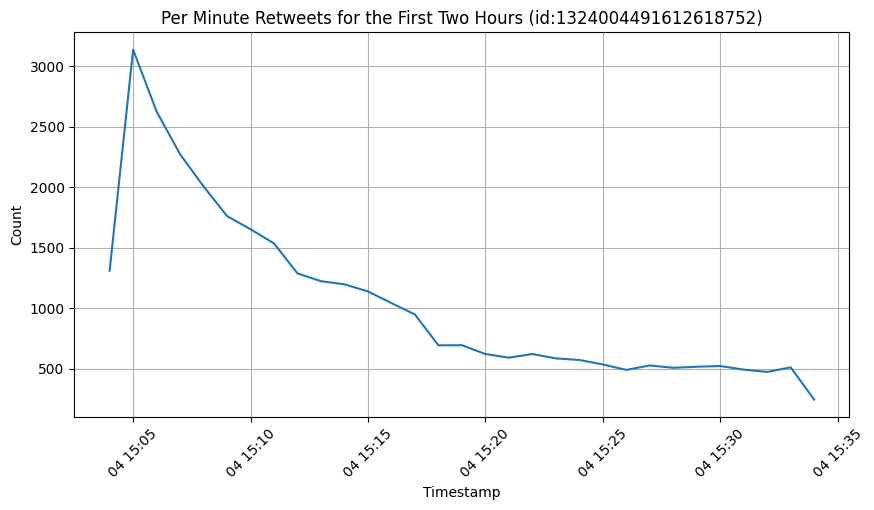

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(first_two_hours_df.index, first_two_hours_df['count'])
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Per Minute Retweets for the First Two Hours (id:{})'.format(id_str))
plt.xticks(rotation=45)
plt.grid()
plt.show()

## 4. Count Cumulative Retweets

In [56]:
df_count = pd.DataFrame(columns=['time','count','id'])
# 0, 1, 2, 8, 13, 19, 24
for i in [0, 1, 2, 8, 13, 19, 24]:
    print(i)
    id_str = restrict_ids[i]
    timestamps = [datetime.strptime(x['created_at'][4:], '%b %d %H:%M:%S %z %Y') for x in res[id_str]]
    retweet_count = [x['retweeted_status']['retweet_count'] for x in res[id_str]]
    # Convert strings to datetime objects
    timestamps = [pd.to_datetime(ts) for ts in timestamps]

    # Remove the seconds from each timestamp
    timestamps_minute = [ts.replace(second=0) for ts in timestamps]

    df_retweet = pd.DataFrame({'time': timestamps_minute, 'count': retweet_count})

    # Calculate the mean of the 'count' column for each timestamp
    average_count = df_retweet.groupby('time')['count'].mean().reset_index()

    average_count['id'] = str(id_str)
    average_count['x'] = range(1, average_count.shape[0] + 1)
    
    df_count = pd.concat([df_count, average_count], ignore_index=True, sort=False)

0
1
2
8
13
19
24


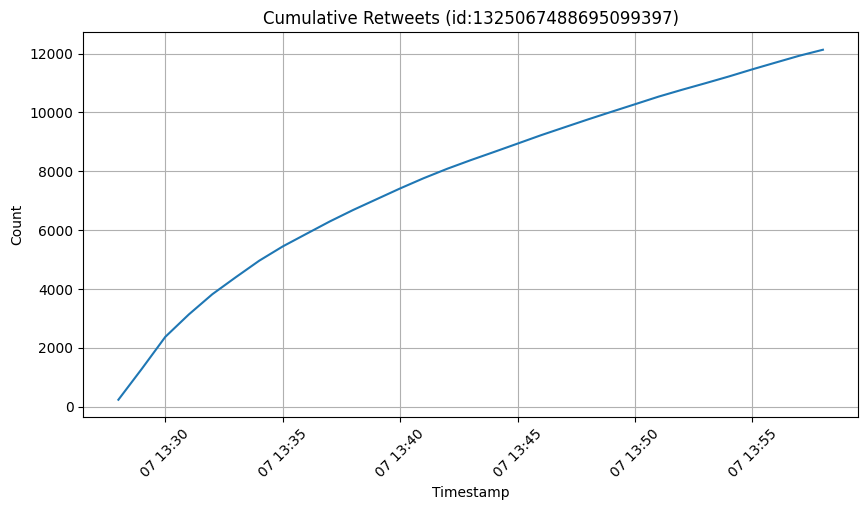

In [60]:
# Plot the time series of average counts
plt.figure(figsize=(10, 5))
plt.plot(average_count['time'], average_count['count'])
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Cumulative Retweets (id:{})'.format(id_str))
plt.xticks(rotation=45)
plt.grid()
plt.show()

In [59]:
df_count.to_csv('/home/jian_frank_cao/Documents/GitHub/Trump-Election-Fraud-Tweets/data/df_count.csv',index=False)